## **Workshop on how to Bridge the gap between Neuroscience & Computational Intelligence for BCI**
## See more detail about workshop here: https://thinknew.github.io/BCIWorkshop/
This notebook aims to demonstrate and teach the following content:

* Demonstrate the importance standardised preprocessing pipeline
* Highlight the typical problems encountered during biosignal timeseries classification
* Develop and tune your own deep learning classification pipeline

# Setting Up the Environment

The prerequisite packages to this tutorial are:


*   [**MNE**](https://mne.tools/stable/install/mne_python.html#installing-mne-python-and-its-dependencies): EEG Data Package
*   [**NumPy**](https://www.scipy.org/install.html): Numerical Computing (SciPy Download Page)
*   [**EinOps**](https://einops.rocks/): Tensor operations using Einstein Notation (Einops Documentation Page)
*   [**SciPy**](https://www.scipy.org/install.html): Scientific Computing
*   [**MatPlotLib**](https://matplotlib.org/users/installing.html): General Purpose Machine Learning Library
*   [**Scikit-Learn**](https://scikit-learn.org/stable/install.html): General Purpose Machine Learning Library
*   [**Tensorflow 2.0**](https://www.tensorflow.org/guide/effective_tf2/): Deep Learning Library from Google Brain

All packages but MNE are available through Google Colab and thus we only need to install MNE.

In [1]:
# Run these from the console if following along locally
!pip install mne
!pip install tensorboardX
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


For the purposes of this workshop, we will be turning off warnings.

In [2]:
# You'll want to comment this out if you plan on modifying this code, to get valuable feedback
import warnings
warnings.filterwarnings('ignore')

Import all of our required modules. This includes various submodules that we'll need including the RobustScaler object from scikit.

In [3]:
from collections import OrderedDict
from pylab import rcParams
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import get_cmap
import numpy as np
import mne
from scipy.io import loadmat
import sklearn
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
import h5py
import json

from einops import rearrange

from google.colab import drive, files

## Reproducibility Matters
When conducting experiments on any given dataset, we want to make sure our changes implemented in the code are caused by said changes, and not a fortunate (or unfortunate) sequence of random operations.

In [4]:
# Set seed to reproduce behaviour
tf.random.set_seed(100)

# Data Analysis
In this section we will load, view, and process our data to prepare it for training and testing.

## Load the EEG data
Here we will load both the raw and preprocessed data.

In [5]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [37]:
# TODO: Define the names of our files
raw_file = './'
processed_file = './'

Extract our raw data.

In [38]:
with open(raw_file, 'r') as f:
  raw_p300_json = json.load(f)
# P300_file = loadmat(raw_file)
print(list(raw_p300_json.keys()))
#raw_p300_json['Data']

['srate', 'ChannelLabels', 'Data']


Extract our processed data.

In [39]:
with open(processed_file, 'r') as f:
  # proc_json = json.load(f)
  proc_json = loadmat(processed_file)
proc_json.keys()

dict_keys(['__header__', '__version__', '__globals__', 'exportdata', 'exportlabel'])

In [55]:
# Do not need to worry about this, just a function to extract the relevant data
# from the preprocessing files
def get_data_and_labels(selected_data):
  keys = selected_data.keys()
  data_key = [k for k in keys if 'data' in k.lower()].pop()
  label_key = [k for k in keys if 'label' in k.lower()].pop()
  data = selected_data[data_key]
  labels = selected_data[label_key]
  if labels.ndim > 1:
    labels = labels.flatten().reshape(-1, 1)
  return data, labels

In [57]:
# Verify that the data shape is what we expect.
# We should see [n_channels, window_size, n_trials]
raw_data = np.array(raw_p300_json['Data'])
proc_data, labels = get_data_and_labels(proc_json)
print("raw data shape: ", raw_data.shape)
print("proc data shape: ", proc_data.shape)

raw data shape:  (7, 384, 20)
proc data shape:  (26, 200, 200)


This kind of data format is less intuitive to understand if we are used to seeing channel information in the last dimension, and 'batched' or 'epoched' information in the first dimension. Let's rearrange this to avoid any confusion later on.

In [1]:
def rearrange_to_bnc(data):
  # TODO: Currently the data shape is (n_channels, time_steps, n_trials) 
  # Rearrange the data format to match the notation
  # (n_trials, time_steps, n_channels).
  pass

Let's check that we have set everything up correctly by visually comparing the raw and processed data for a select channel.


In [62]:
raw_data = rearrange_to_bnc(raw_data)
proc_data = rearrange_to_bnc(proc_data)

In [28]:
ch_to_plot = 0 # select a valid channel for plotting
scaler = 3e-5 # change for larger or small separation between singular plots
color = 'tab:blue' # change for different colours

In [31]:
# Plot
channel = raw_p300_json['ChannelLabels'][ch_to_plot]
raw_data_ch = raw_data[..., ch_to_plot]
proc_data_ch = proc_data[..., ch_to_plot]

(20, 384)

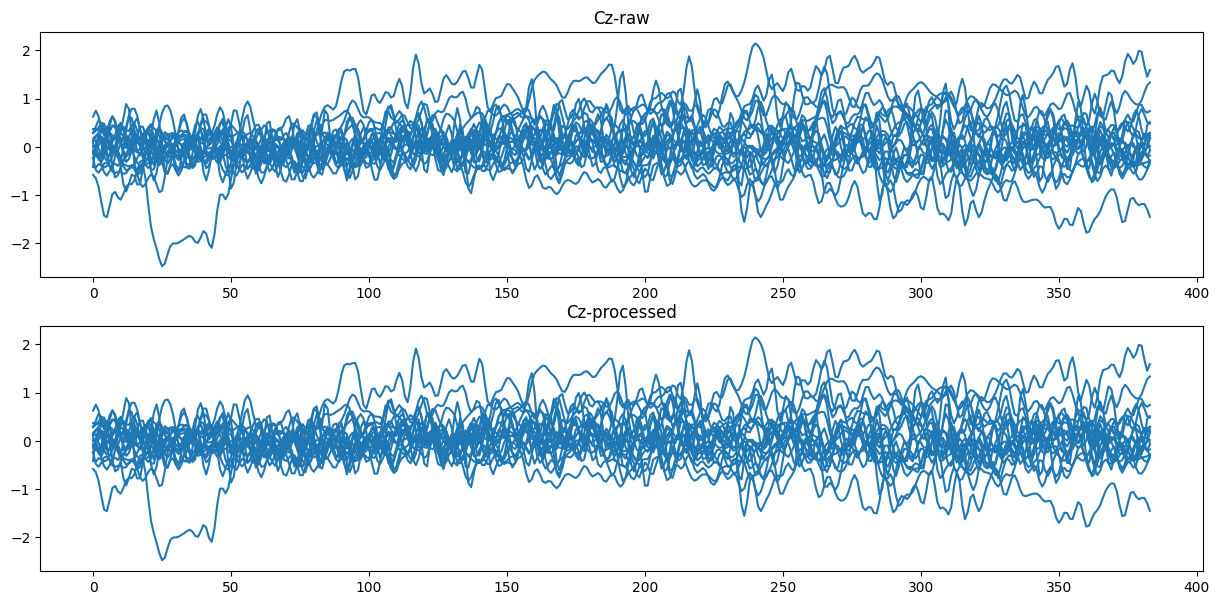

In [34]:
rcParams['figure.figsize'] = 15, 7
plt.subplot(2,1,1)
plt.title(channel+'-raw')
for i, data in enumerate(raw_data_ch):
    data += i*scaler
    plt.plot(data, color=color)

plt.subplot(2,1,2)
plt.title(channel+'-processed')
for i, data in enumerate(proc_data_ch):
    data += i*scaler
    plt.plot(data, color=color)

# Data Preparation
We need to scale and split our data to feed into our model for training.

Let's choose what channels we want to train our neural network with.

*Note: the P300 signal is a visually stimulated biomarker, expressed in the occipital lobe.*

In [76]:
# Choose what channels we want to select to train on.
channels_to_train = [0,1] # Select multiple with a list: [0, 1, 2]

In [77]:
# By default we have selected the processed data, what happens if we choose
# the raw data?
P300_data_c = proc_data[..., channels_to_train]
P300_label = labels

Now that we have selected our data for training, we need to setup our training and testing dataset.

In [78]:
from sklearn.model_selection import train_test_split
P300_data_c_train, P300_data_c_test, P300_label_c_train, P300_label_c_test = \
    train_test_split(P300_data_c, P300_label, test_size=0.2, random_state=123)

print(P300_data_c_train.shape)
print(P300_data_c_test.shape)

(160, 200, 2)
(40, 200, 2)


Normalisation is an important step to help reduce bias in our data and ensure the model weighs each channel as evenly as possible.

Let's normalize our data over each channel to fit between 0 and 1 (i.e. for each channel, all the values are between 0 and 1).

In [95]:
# MinMax Normalisation function
# TODO: Is a way to linearise this calculation and speed it up?
def normalise(data):
  n_channels = data.shape[-1]
  for c in range(n_channels):
    data_to_scale = data[..., c]
    scaler = MinMaxScaler()
    data[..., c] = scaler.fit_transform(data_to_scale)
  return data

In [98]:
P300_data_c_train = normalise(P300_data_c_train)
P300_data_c_test = normalise(P300_data_c_test)

# Neural Network

Initialize parameters including EEG related Metadata.


*   **eeg_sample_count**:  Number of samples we're training our network with
*   **learning_rate**:     How fast the network tends to change its weights
*   **loss**:              Function for evaluating our model against the dataset
*   **batch_size**:        Batching the dataset for training
*   **eeg_sample_length**: Number of datapoints per sample
*   **number_of_classes**: Number of output classes (a scalar value that represents probability of input belonging to p300)
*   **hidden1**: Number of neurons in the first hidden layer
*   **hidden2**: Number of neurons in the second hidden layer
*   **hidden3**: Number of neurons in the third hidden layer
*   **output**: Number of neurons in the output layer

In [104]:
# Initialize parameters
eeg_sample_count = 240 # How many samples are we training
epochs = 10 # number of times we loop through our training data
learning_rate = 1e-3 # How hard the network will correct its mistakes while learning
loss = 'mse' # Metric for our optimizer to minimise
batch_size = 32 # Number of samples in our batch
eeg_sample_length = 226 # Number of eeg data points per sample
number_of_classes = 1 # We want to answer the "is this a P300?" question
hidden1 = 500 # Number of neurons in our first hidden layer
hidden2 = 1000 # Number of neurons in our second hidden layer
hidden3 = 100 # Number of neurons in our third hidden layer
penultimate = 10 # Number of neurons in our output layer
metrics = ['binary_accuracy'] # Metrics for us to monitor during training and tuning

We use our hyperparameters to define our neural network model.

In [105]:
## Define the network
P300_model = keras.Sequential()

# Input Layer (Size 226 -> 500)
P300_model.add(layers.Dense(hidden1, activation="relu", name="Input_Layer"))

# Hidden Layer (Size 500 -> 1000)
P300_model.add(layers.Dense(hidden2, activation="relu", name="Hidden_Layer1"))

# Hidden Layer (Size 1000 -> 100)
P300_model.add(layers.Dense(hidden3, activation="relu", name="Hidden_Layer2"))

# Hidden Layer (Size 100 -> 10)
P300_model.add(layers.Dense(penultimate, activation="relu", name="Hidden_Layer3"))

# Handle multi-channel inputs.
P300_model.add(layers.Flatten())

# Output Layer (Size 10 -> 1)
P300_model.add(layers.Dense(number_of_classes, activation="sigmoid", name="Output_Layer"))

# Define a learning function, needs to be reinitialized every load
optimizer = keras.optimizers.Adam(learning_rate)
# After the model is created, we then config the model with losses and metrics
P300_model.compile(optimizer=optimizer,
             loss=loss,
             metrics=metrics)

Now that we have our model defined, we can train and test on our dataset.

Epoch 1/10
5/5 [==============================] - 4s 490ms/step - loss: 0.2151 - binary_accuracy: 0.9000
Epoch 2/10
5/5 [==============================] - 3s 722ms/step - loss: 0.1025 - binary_accuracy: 0.9062
Epoch 3/10
5/5 [==============================] - 3s 553ms/step - loss: 0.0921 - binary_accuracy: 0.9062
Epoch 4/10
5/5 [==============================] - 2s 459ms/step - loss: 0.0929 - binary_accuracy: 0.9062
Epoch 5/10
5/5 [==============================] - 2s 464ms/step - loss: 0.0932 - binary_accuracy: 0.9062
Epoch 6/10
5/5 [==============================] - 2s 467ms/step - loss: 0.0934 - binary_accuracy: 0.9062
Epoch 7/10
5/5 [==============================] - 3s 551ms/step - loss: 0.0935 - binary_accuracy: 0.9062
Epoch 8/10
5/5 [==============================] - 4s 727ms/step - loss: 0.0935 - binary_accuracy: 0.9062
Epoch 9/10
5/5 [==============================] - 2s 467ms/step - loss: 0.0934 - binary_accuracy: 0.9062
Epoch 10/10
5/5 [==============================] - 2s 4

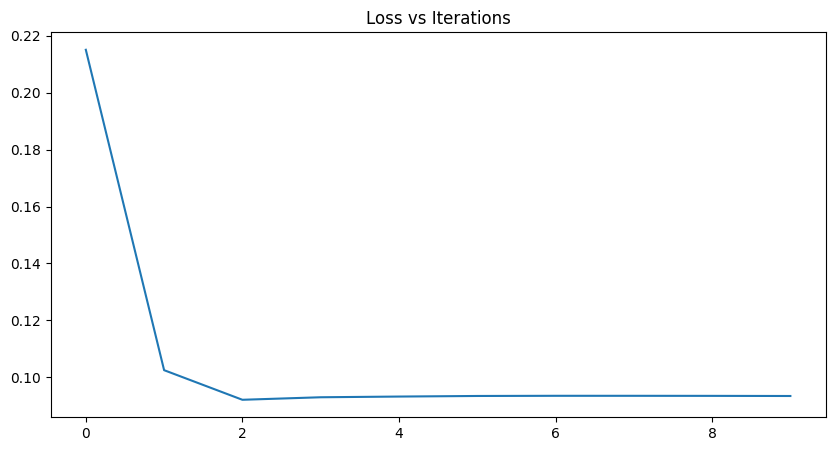

In [106]:
# Make sure we're starting from untrained every time
#tutorial_model = keras.models.load_model('/home/tutorial_model_default_state')
#tf.compat.v1.initializers.global_variables()
mse_list = P300_model.fit(P300_data_c_train, P300_label_c_train, batch_size=batch_size,
                          epochs=epochs, verbose=1)

# Define a learning function, needs to be reinitialized every load
# optimizer = torch.optim.Adam(tutorial_model.parameters(), lr = learning_rate)

# Use our training procedure with the sample data
print("Below is the loss graph for dataset training session")
loss_data = mse_list.history['loss']
# Plot a nice loss graph at the end of training
rcParams['figure.figsize'] = 10, 5
plt.title("Loss vs Iterations")
plt.plot(list(range(0, len(loss_data))), loss_data)
plt.show()

## Classification Performance

In [107]:
# Classify our positive test dataset and print the results
classification_test = np.round(P300_model.predict(P300_data_c_test))
print("classification max: ", classification_test.max())
print(classification_test.shape)
from sklearn.metrics import classification_report
print(classification_report(P300_label_c_test, classification_test))

2/2 [==============================] - 1s 77ms/step
classification max:  0.0
(40, 1)
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        35
           1       0.00      0.00      0.00         5

    accuracy                           0.88        40
   macro avg       0.44      0.50      0.47        40
weighted avg       0.77      0.88      0.82        40



# Review
How did your model do? How did your model do with you data after signal processing? What hyperparameters significantly affected the performance?